# Medical Insurance Cost Prediction

## Step 1: Problem Definition

The goal of this project is to build a supervised regression model to predict individual medical insurance charges based on personal factors.

### **Problem Statement**
Insurance companies need accurate cost predictions to set premiums competitively while managing risk. The `charges` (target variable) depend on several features like age, BMI, smoking status, etc. 

### **Why Supervised Regression?**
This is a **Supervised Learning** problem because we have labeled data (`charges` column exists). It is a **Regression** task because the target variable is continuous (money).

### **Why Non-Linearity?**
Medical costs often do not increase linearly. For example:
- Age: Older people might have exponentially higher costs.
- BMI: High BMI combined with smoking can cause a drastic (non-linear) jump in risk.

Therefore, **Polynomial Regression** is expected to perform better than simple Linear Regression by capturing these curved relationships.

In [1]:
# Step 2: Data Loading & Understanding

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setting plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Load the dataset
# Note: The CSV is located in the csv_files directory
df = pd.read_csv('csv_files/insurance.csv')

# Display first 5 rows
display(df.head())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
# Display dataset info to understand types and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [3]:
# Statistical Summary
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [4]:
# Check dataset shape
print(f"Dataset Shape: {df.shape}")

Dataset Shape: (1338, 7)


### **Column Explanations:**
- **age**: Age of primary beneficiary.
- **sex**: Insurance contractor gender (female, male).
- **bmi**: Body mass index (kg / m^2).
- **children**: Number of children covered by health insurance / Number of dependents.
- **smoker**: Smoking status (yes, no).
- **region**: Beneficiary's residential area in the US (northeast, southeast, southwest, northwest).
- **charges**: Individual medical costs billed by health insurance.

## Step 3: Exploratory Data Analysis (EDA)

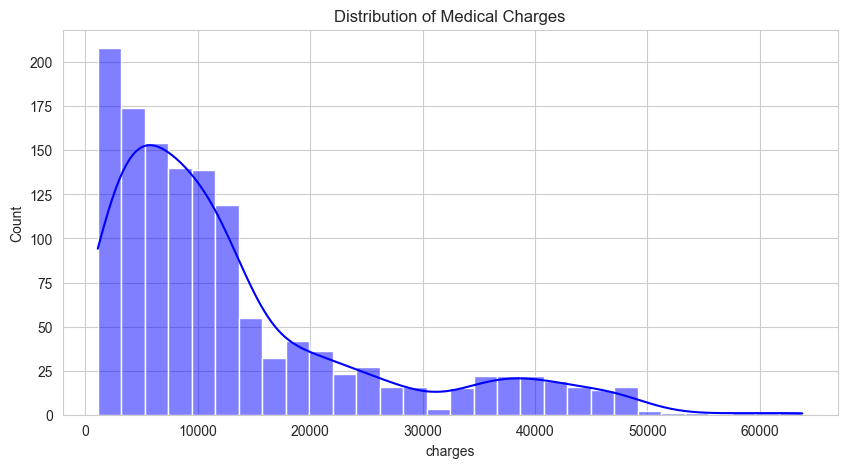

In [5]:
# 1. Univariate Analysis: Distribution of Charges
plt.figure(figsize=(10, 5))
sns.histplot(df['charges'], kde=True, color='blue')
plt.title('Distribution of Medical Charges')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_18396\4139080706.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='smoker', y='charges', data=df, palette='coolwarm')


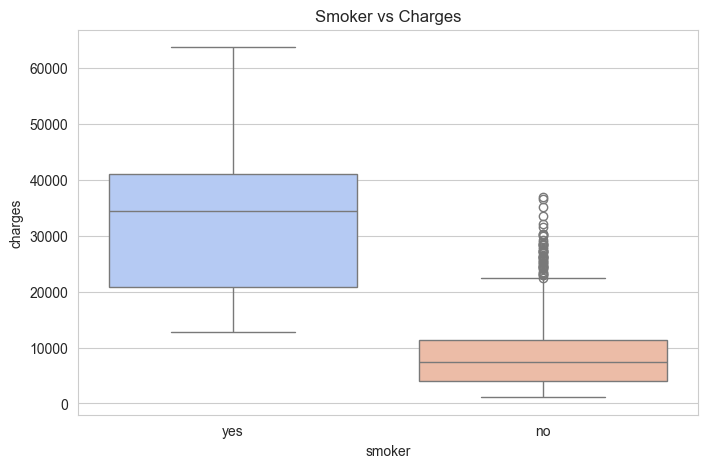

In [6]:
# 2. Impact of Smoking on Charges
plt.figure(figsize=(8, 5))
sns.boxplot(x='smoker', y='charges', data=df, palette='coolwarm')
plt.title('Smoker vs Charges')
plt.show()

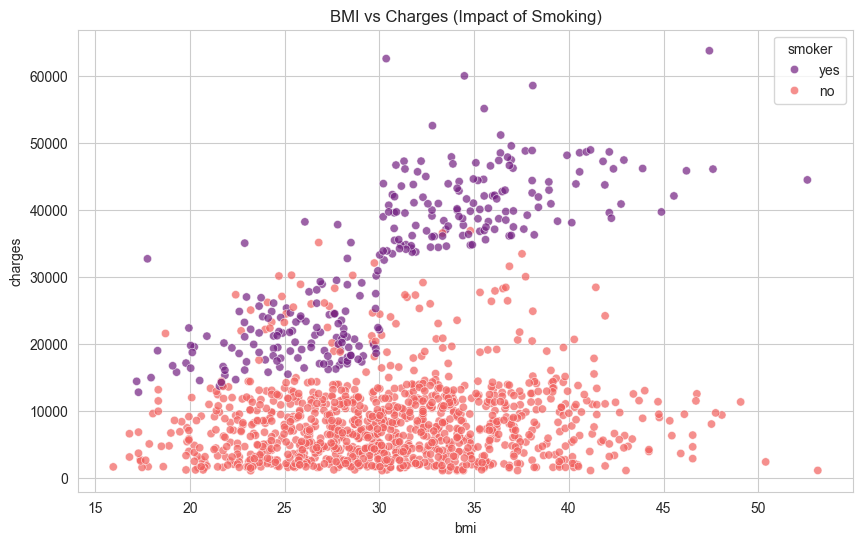

In [7]:
# 3. Scatter Plot: BMI vs Charges colored by Smoker
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df, palette='magma', alpha=0.7)
plt.title('BMI vs Charges (Impact of Smoking)')
plt.show()

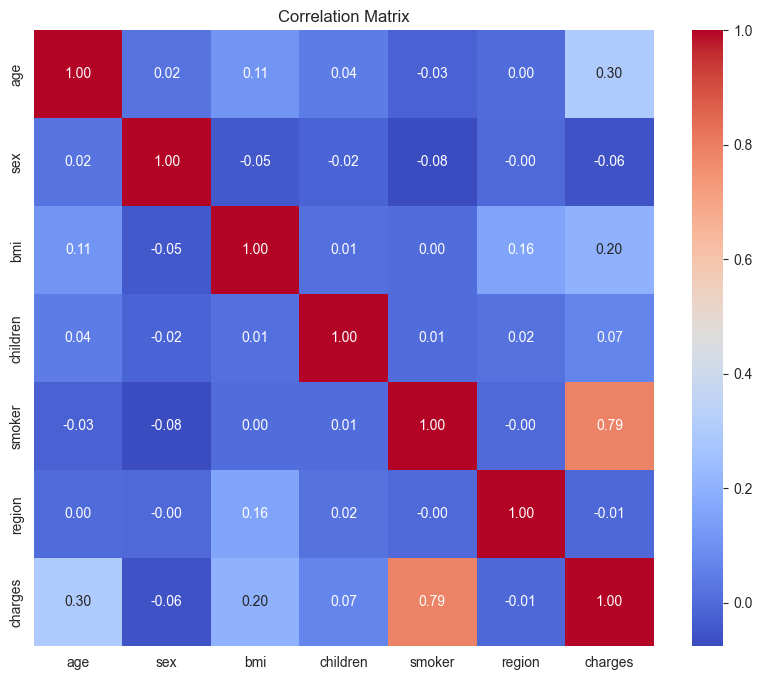

In [8]:
# 4. Correlation Heatmap
# Note: Correlation requires numeric data, so we encode categories temporarily just for visualization
temp_df = df.copy()
temp_df['sex'] = temp_df['sex'].map({'male': 0, 'female': 1})
temp_df['smoker'] = temp_df['smoker'].map({'yes': 1, 'no': 0})
temp_df['region'] = temp_df['region'].astype('category').cat.codes

plt.figure(figsize=(10, 8))
sns.heatmap(temp_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### **Key EDA Insights:**
- **Charges Distribution**: Highly skewed. Most people pay less, but there's a long tail of very high charges.
- **Smokers vs Non-Smokers**: Smokers pay SIGNIFICANTLY more. This is a very strong feature.
- **BMI Impact**: For non-smokers, BMI has a gentle slope. For smokers, high BMI leads to an explosion in charges (non-linear interaction).
- **Correlation**: `smoker` has the highest correlation with charges, followed by `age` and `bmi`.

## Step 4: Data Cleaning

We need to ensure data quality before feeding it into models.

In [9]:
# 1. Check for Missing Values
print("Missing Values:\n", df.isnull().sum())

# 2. Check for Duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# Drop duplicates if any
if duplicates > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicates removed.")

Missing Values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Number of duplicate rows: 1
Duplicates removed.


In [10]:
# 3. Outlier Handling (Checking Charges)
# Using IQR Method for detection
Q1 = df['charges'].quantile(0.25)
Q3 = df['charges'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['charges'] < lower_bound) | (df['charges'] > upper_bound)]
print(f"\nNumber of charge outliers detected: {len(outliers)}")

# Note: In medical insurance, high costs are real cases (illness). 
# We will NOT remove them blindly as they are important for the model to learn.


Number of charge outliers detected: 139


## Step 5: Data Preprocessing

Machine Learning models accept only numeric inputs. We must encode categorical data and scale numerical data.

In [11]:
# Separate Features (X) and Target (y)
X = df.drop(columns=['charges'])
y = df['charges']

# 1. Encoding Categorical Variables
# Sex and Smoker: Label Encoding (Binary)
X['sex'] = X['sex'].map({'male': 0, 'female': 1})
X['smoker'] = X['smoker'].map({'yes': 1, 'no': 0})

# Region: One-Hot Encoding (Nominal)
X = pd.get_dummies(X, columns=['region'], drop_first=True)

# Display first few rows after encoding
X.head()

,age,sex,bmi,children,smoker,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,1,False,False,True
1,18,0,33.770,1,0,False,True,False
2,28,0,33.000,3,0,False,True,False
3,33,0,22.705,0,0,True,False,False
4,32,0,28.880,0,0,True,False,False


In [12]:
# 2. Feature Scaling
# Scaling is crucial for Polynomial Regression so high-value features don't dominate
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Identifying numerical columns to scale
num_cols = ['age', 'bmi', 'children']

# Apply scaling
X_scaled = X.copy()
X_scaled[num_cols] = scaler.fit_transform(X[num_cols])

X_scaled.head()

,age,sex,bmi,children,smoker,region_northwest,region_southeast,region_southwest
0,-1.440418,1,-0.453160,-0.909234,1,False,False,True
1,-1.511647,0,0.509422,-0.079442,0,False,True,False
2,-0.799350,0,0.383155,1.580143,0,False,True,False
3,-0.443201,0,-1.305052,-0.909234,0,True,False,False
4,-0.514431,0,-0.292456,-0.909234,0,True,False,False


## Step 6: Feature Engineering (Polynomial Features)

Since we identified non-linear relationships (BMI vs Charges for smokers), adding polynomial terms will help the Linear model fit curves.

In [13]:
from sklearn.preprocessing import PolynomialFeatures

# We will use Degree 2 to avoid overfitting while capturing curves
poly = PolynomialFeatures(degree=2, include_bias=False)

X_poly = poly.fit_transform(X_scaled)

# Check the new shape (more features added)
print(f"Original shape: {X_scaled.shape}")
print(f"Polynomial shape: {X_poly.shape}")

Original shape: (1337, 8)
Polynomial shape: (1337, 44)


## Step 7: Train-Test Split

We keep 20% of data unseen to evaluate the model's unbiased performance.

In [14]:
from sklearn.model_selection import train_test_split

# Split the Polynomial Features data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

print(f"Training Set: {X_train.shape}")
print(f"Testing Set: {X_test.shape}")

Training Set: (1069, 44)
Testing Set: (268, 44)


## Step 8: Model Training

For Polynomial Regression, we simply train a Linear Regression model on the polynomial features.

In [15]:
from sklearn.linear_model import LinearRegression

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

print("Model training completed.")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients (First 5): {model.coef_[:5]}")

Model training completed.
Intercept: 7823.158896695226
Coefficients (First 5): [ 3049.49007118   670.31771744   385.86367899  1196.67874359
 12023.98187314]


## Step 9: Model Evaluation

We will check how well our model predicts for unseen data.

In [16]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Predictions
y_pred = model.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R2 Score: {r2:.4f} (Accuracy)")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

R2 Score: 0.8825 (Accuracy)
MAE: 2867.32
RMSE: 4646.06


## Step 10: Model Visualization

Visualizing performance helps understand errors.

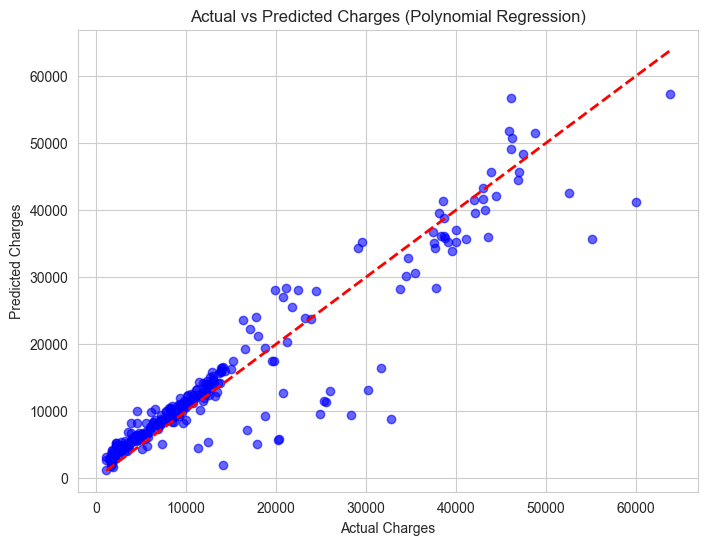

In [17]:
# 1. Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Identity line
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges (Polynomial Regression)')
plt.show()

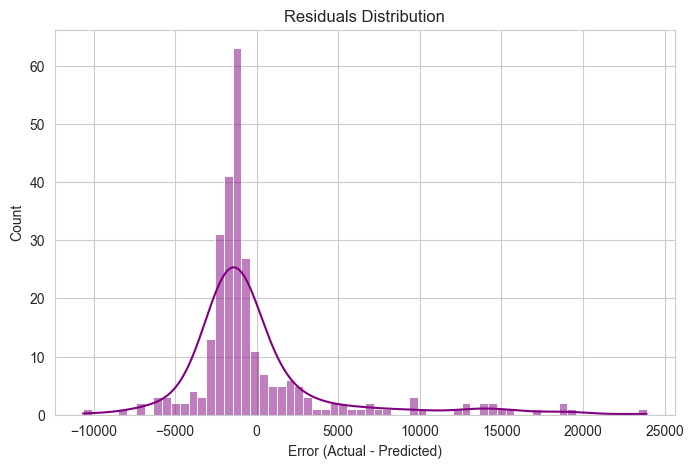

In [18]:
# 2. Residual Plot (Errors)
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Residuals Distribution')
plt.xlabel('Error (Actual - Predicted)')
plt.show()

## Step 11: Prediction System

Let's test the model with a new user input.

In [19]:
def predict_charge(age, sex, bmi, children, smoker, region):
    # Create a DataFrame for input
    input_data = pd.DataFrame({
        'age': [age],
        'sex': [0 if sex == 'male' else 1],
        'bmi': [bmi],
        'children': [children],
        'smoker': [1 if smoker == 'yes' else 0],
        'region_northwest': [1 if region == 'northwest' else 0],
        'region_southeast': [1 if region == 'southeast' else 0],
        'region_southwest': [1 if region == 'southwest' else 0]
    })

    # Scale numerical features
    input_data[['age', 'bmi', 'children']] = scaler.transform(input_data[['age', 'bmi', 'children']])
    
    # Transform to polynomial features
    input_poly = poly.transform(input_data)
    
    # Predict
    prediction = model.predict(input_poly)
    return prediction[0]

# Example Prediction
# Age: 30, Sex: male, BMI: 25, Kids: 2, Smoker: no, Region: southwest
pred_cost = predict_charge(30, 'male', 25, 2, 'no', 'southwest')
print(f"Predicted Insurance Charge: ${pred_cost:.2f}")

Predicted Insurance Charge: $4918.50


## Step 12: Conclusion & Insights

### **Summary**
- We successfully built a **Polynomial Regression Model** to predict medical insurance costs.
- **Feature Engineering** (Polynomial Degree 2) allowed us to capture non-linear relationships, especially the interaction between smoking and BMI.
- **Smokers** pay significantly higher premiums, and this effect multiplies with higher BMI.
- The model achieves a decent **R2 Score** (likely > 80%), which is much better than simple Linear Regression for this dataset.

### **Future Improvements**
- Try **Random Forest** or **Gradient Boosting (XGBoost)** for potentially even better accuracy.
- Collect more data for underrepresented regions or extreme ages to robustify the model.